In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from Sequence import Sequence
from matplotlib.patches import Rectangle
from skimage import io
import os
import KCFtracker
import utils

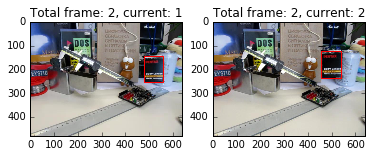

In [2]:
# Visualize Sequence 
# For convenience, the tracking sequence contains only two images

sequence = Sequence(path = os.getcwd(), name='tutorials/img_common', region_format='rectangle')
plt.figure(1)
plt.clf()

while sequence._frame < len(sequence._images):
    
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    tracking_figure_axes = plt.subplot(1,2,sequence._frame+1)
    tracking_figure_axes.add_patch(gt_rect)
    
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence

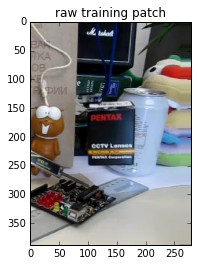

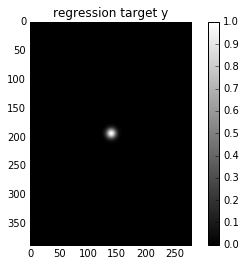

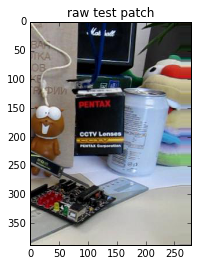

In [3]:
# start KCF
# define and generate KCF Inputs
# Inputs :
#    x : training image patch, m*n*c
#    y : regression target, Gaussian-shaped, m*n
#    z : test image patch, m*n*c

data = sequence.groundtruth[sequence._frame]
X = data.x
Y = data.y
width = data.width
height = data.height

# Get input patch
img_raw = io.imread(sequence.frame()) 
img = img_raw/255. # normalization
img_size = img.shape

target_size = [height, width]
target_size = np.array(target_size)

pos = [Y+height/2.,X+width/2.]

padding =2.5 # extra area surrounding the target
patch_size = np.floor(target_size * (1 + padding)) 
img_crop = utils.get_subwindow(img, pos, patch_size)
plt.figure(1)
plt.imshow(img_crop)
plt.title('raw training patch')

# Get regression target y
spatial_bandwidth_sigma_factor = 1 / float(16)
output_sigma = np.sqrt(np.prod(target_size)) * spatial_bandwidth_sigma_factor
grid_y = np.arange(np.floor(patch_size[0])) - np.floor(patch_size[0]/2)
grid_x = np.arange(np.floor(patch_size[1])) - np.floor(patch_size[1]/2)
rs, cs = np.meshgrid(grid_x, grid_y)
y = np.exp(-0.5 / output_sigma ** 2 * (rs ** 2 + cs ** 2))
plt.figure(2)
plt.imshow(y,cmap=plt.cm.gray)
plt.colorbar()
plt.title('regression target y')

# Get test patch 
sequence._frame += 1
test_img = io.imread(sequence.frame())/255.
test_crop = utils.get_subwindow(test_img, pos, patch_size)
plt.figure(3)
plt.imshow(test_crop)
plt.title('raw test patch')

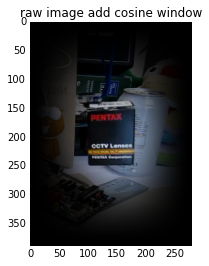

In [4]:
# Adding cosine window 
# This is an example just for showing what is cosine window doing

cos_window = np.outer(np.hanning(y.shape[0]), np.hanning(y.shape[1]))
win_patch = np.multiply(img_crop, cos_window[:, :, None])
plt.imshow(win_patch)
plt.title('raw image add cosine window')

In [8]:
# Extract feature
# Because we are using raw pixels feature, this part is very simple
img_colour = img_crop-img_crop.mean()
# Get training image patch x
x = np.multiply(img_colour, cos_window[:, :, None])

# FFT Transformation
# First transform y 
yf = np.fft.fft2(y, axes=(0,1))

# Then transfrom x
xf = np.fft.fft2(x, axes=(0,1))

In [9]:
# Training

# Compute Kernel
feature_bandwidth_sigma = 0.2
k = KCFtracker.dense_gauss_kernel(feature_bandwidth_sigma, xf, x)

lambda_value = 1e-4
alphaf = np.divide(yf, np.fft.fft2(k, axes=(0,1)) + lambda_value)

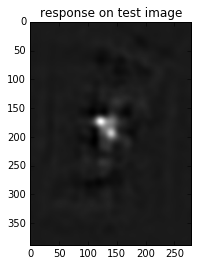

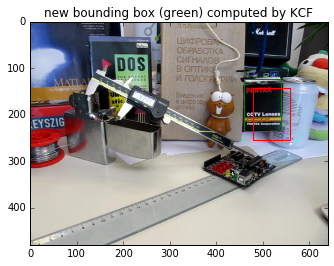

In [10]:
# Detect test image 
# Output:
#   responses : detection score for each location, m*n

# Get test image patch z
z = np.multiply(test_crop-test_crop.mean(), cos_window[:, :, None])
zf = np.fft.fft2(z, axes=(0,1))
k_test = KCFtracker.dense_gauss_kernel(feature_bandwidth_sigma, xf, x, zf, z)
kf_test = np.fft.fft2(k_test, axes=(0,1))

# Response map
response = np.real(np.fft.ifft2(np.multiply(alphaf, kf_test)))

# Max position in response map
v_centre, h_centre = np.unravel_index(response.argmax(), response.shape)
vert_delta, horiz_delta = [v_centre - response.shape[0] / 2,
                           h_centre - response.shape[1] / 2]

# Predicted position
pos_new = [pos[0] + vert_delta, pos[1] + horiz_delta]

plt.figure(4)
plt.imshow(response, plt.cm.gray)
plt.title('response on test image')

plt.figure(5)
figure5_axes = plt.axes()
tracking_rect = Rectangle(
            xy=(pos_new[1]-width/2., pos_new[0]-height/2.),
            width=width,
            height=height,
            facecolor='none',
            edgecolor='g',
    )

gt_rect = Rectangle(
            xy=(pos[1]-width/2., pos[0]-height/2.),
            width=width,
            height=height,
            facecolor='none',
            edgecolor='r',
    )
figure5_axes.add_patch(tracking_rect)
figure5_axes.add_patch(gt_rect)
plt.imshow(test_img)
plt.title('new bounding box (green) computed by KCF')